In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from collections import defaultdict, Counter

In [2]:
DATA_DIR = '/work/InternalMedicine/s223850/ED-StaticDynamic/static_dynamic_ds_parallel/dynamic_186.csv'
df = pd.read_csv(DATA_DIR)
df['Calculated_DateTime'] = pd.to_datetime(df['Calculated_DateTime'])

unamed_cols = [col for col in df.columns if 'unname' in col.lower()]
if len(unamed_cols) > 0:
    df.drop(columns=unamed_cols, inplace=True)

for col in df.columns:
    if col in ['Calculated_DateTime', 'PAT_ENC_CSN_ID']:
        continue
    if df[col].isna().sum() > 0:
        df.loc[df[col].isna(), col] = 'Unknown'
    

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10175477 entries, 0 to 10175476
Data columns (total 8 columns):
 #   Column               Dtype         
---  ------               -----         
 0   PAT_ENC_CSN_ID       int64         
 1   Type                 object        
 2   EVENT_NAME           object        
 3   Order_Status         object        
 4   Result_Flag          object        
 5   Primary_DX_Name      object        
 6   Primary_DX_ICD10     object        
 7   Calculated_DateTime  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 621.1+ MB


In [4]:
df.isna().sum()

PAT_ENC_CSN_ID         0
Type                   0
EVENT_NAME             0
Order_Status           0
Result_Flag            0
Primary_DX_Name        0
Primary_DX_ICD10       0
Calculated_DateTime    0
dtype: int64

# When does each event occur within each type?


In [5]:
df = df.sort_values(by='Calculated_DateTime')

In [6]:
df['time_elapsed_min'] = df.groupby('PAT_ENC_CSN_ID')['Calculated_DateTime'].transform(lambda x: (x-x.iloc[0]).dt.total_seconds()/60)

In [7]:
pat_groups = df.groupby('PAT_ENC_CSN_ID')

In [8]:
type_cntr = defaultdict(list)
for idx, (pat_id, df_grp) in enumerate(pat_groups):
    for ttype, df_type in df_grp.groupby('Type'):
        if ttype=='Lab Order - Result':
            # type_cntr[ttype].extend(list(zip(df_type['EVENT_NAME'].tolist(), df_type['Result_Flag'].tolist(), df_type['time_elapsed_min'].tolist())))
            type_cntr[ttype].extend(list(zip(df_type['EVENT_NAME'].tolist(), df_type['time_elapsed_min'].tolist())))
        else:
            type_cntr[ttype].extend(list(zip(df_type['EVENT_NAME'].tolist(), df_type['time_elapsed_min'].tolist())))
        

In [9]:
def analyze_type(ttype='Event'):
    df_event_time = pd.DataFrame(type_cntr[ttype], columns=[ttype, 'time_elapsed_min'])
    event_time_avg = df_event_time.groupby(ttype)['time_elapsed_min'].mean().sort_values()
    event_counts_frame = df_event_time[ttype].value_counts().to_frame()
    event_data = event_counts_frame.merge(event_time_avg, how='outer', left_index=True, right_index=True)
    thr = event_data['time_elapsed_min'].mean()
    
    plt.figure(figsize=(22, 14))
    sns.scatterplot(data=event_data, x='time_elapsed_min', y=ttype)
    for i in range(len(event_data)):
        if event_data[ttype].iloc[i] > thr:
            plt.text(event_data['time_elapsed_min'].iloc[i] + 0.1, event_data[ttype].iloc[i], event_data.index[i], horizontalalignment='left',
                fontdict=dict(size=10, weight='normal'))
    plt.show()
    

    fig, axes = plt.subplots(2,4, figsize=(26, 18), constrained_layout=True)
    for i in range(1, 8):
        events = event_data.loc[(event_data['time_elapsed_min']>=(i-1)*60)&(event_data['time_elapsed_min']<(i*60)), ttype]
        top_20 = events.sort_values(ascending=False).iloc[:20]
        wc = wordcloud.WordCloud(background_color='white')
        f = wc.generate_from_frequencies(events.sort_values(ascending=False).iloc[:20])
        axes[(i-1)//4][(i-1)%4].imshow(f, interpolation='bilinear')
        axes[(i-1)//4][(i-1)%4].set_title(f'Between {i-1} and {i} hours')
    plt.show()

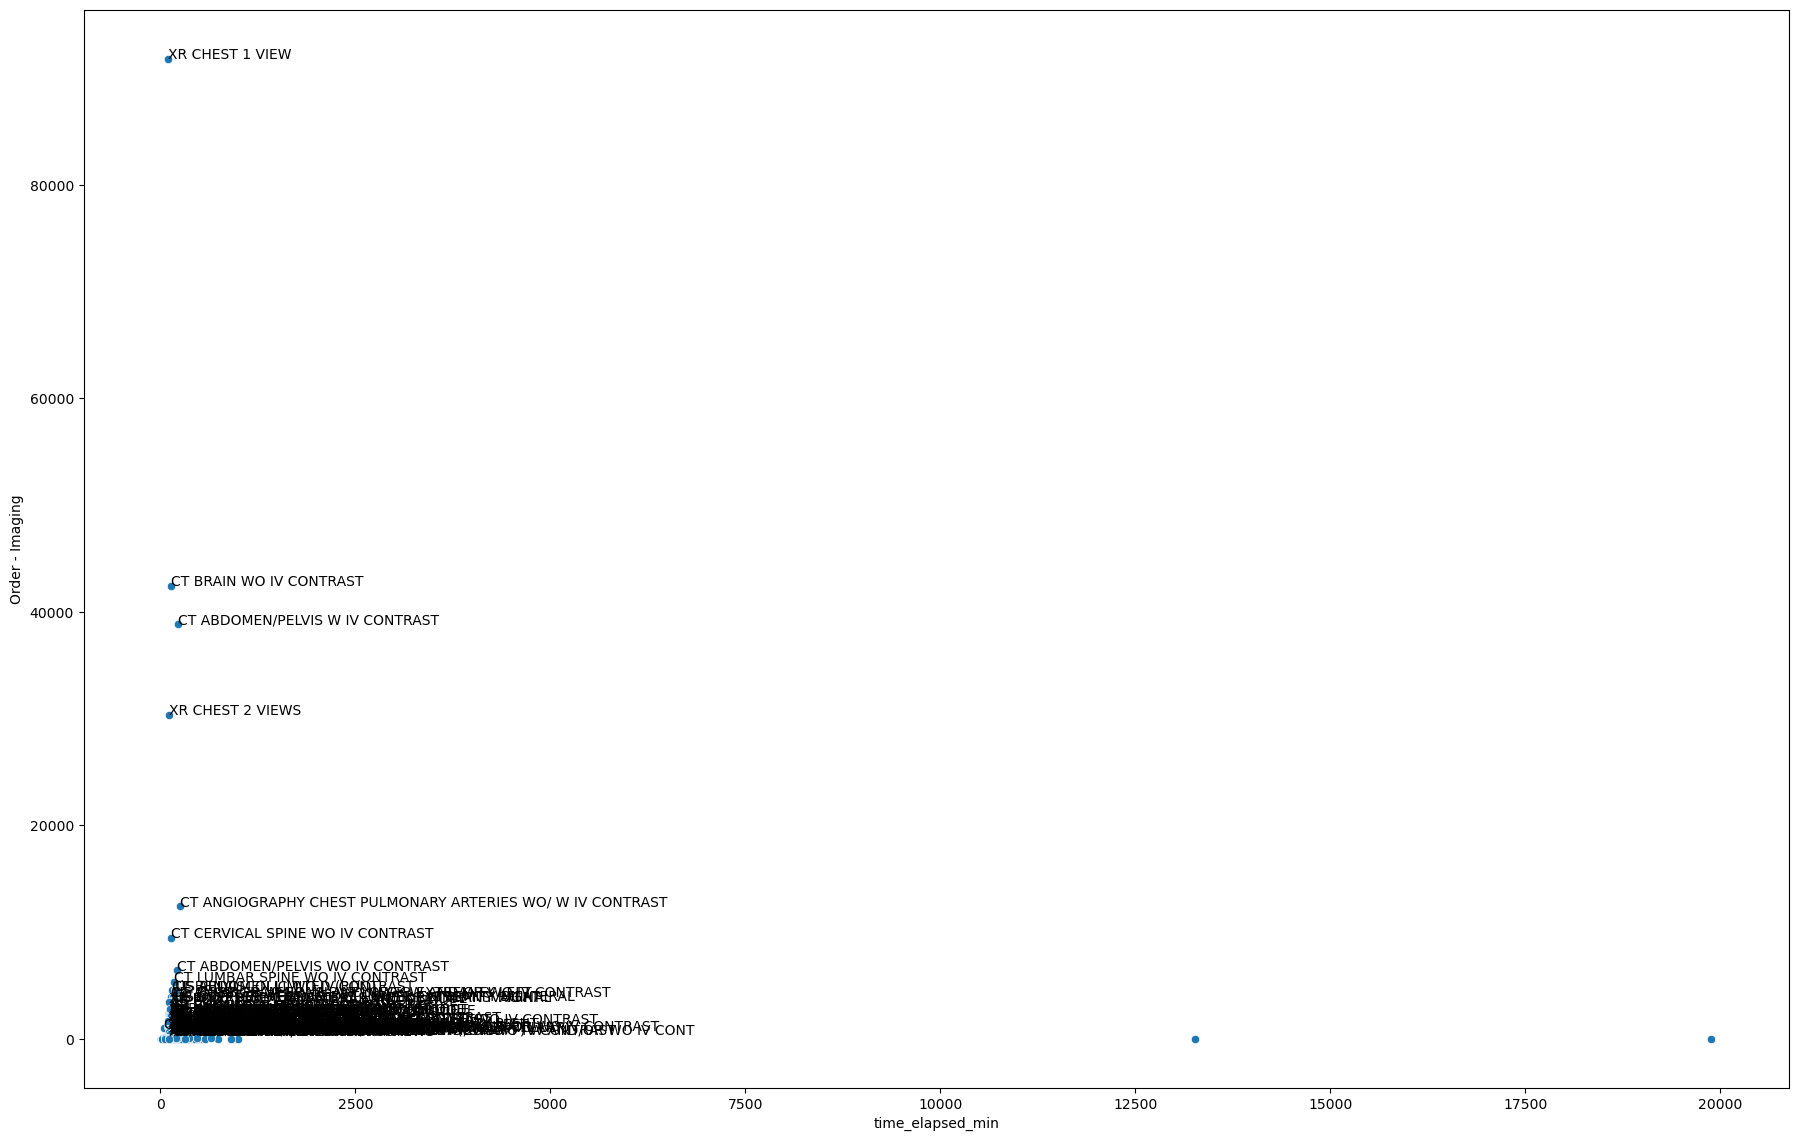

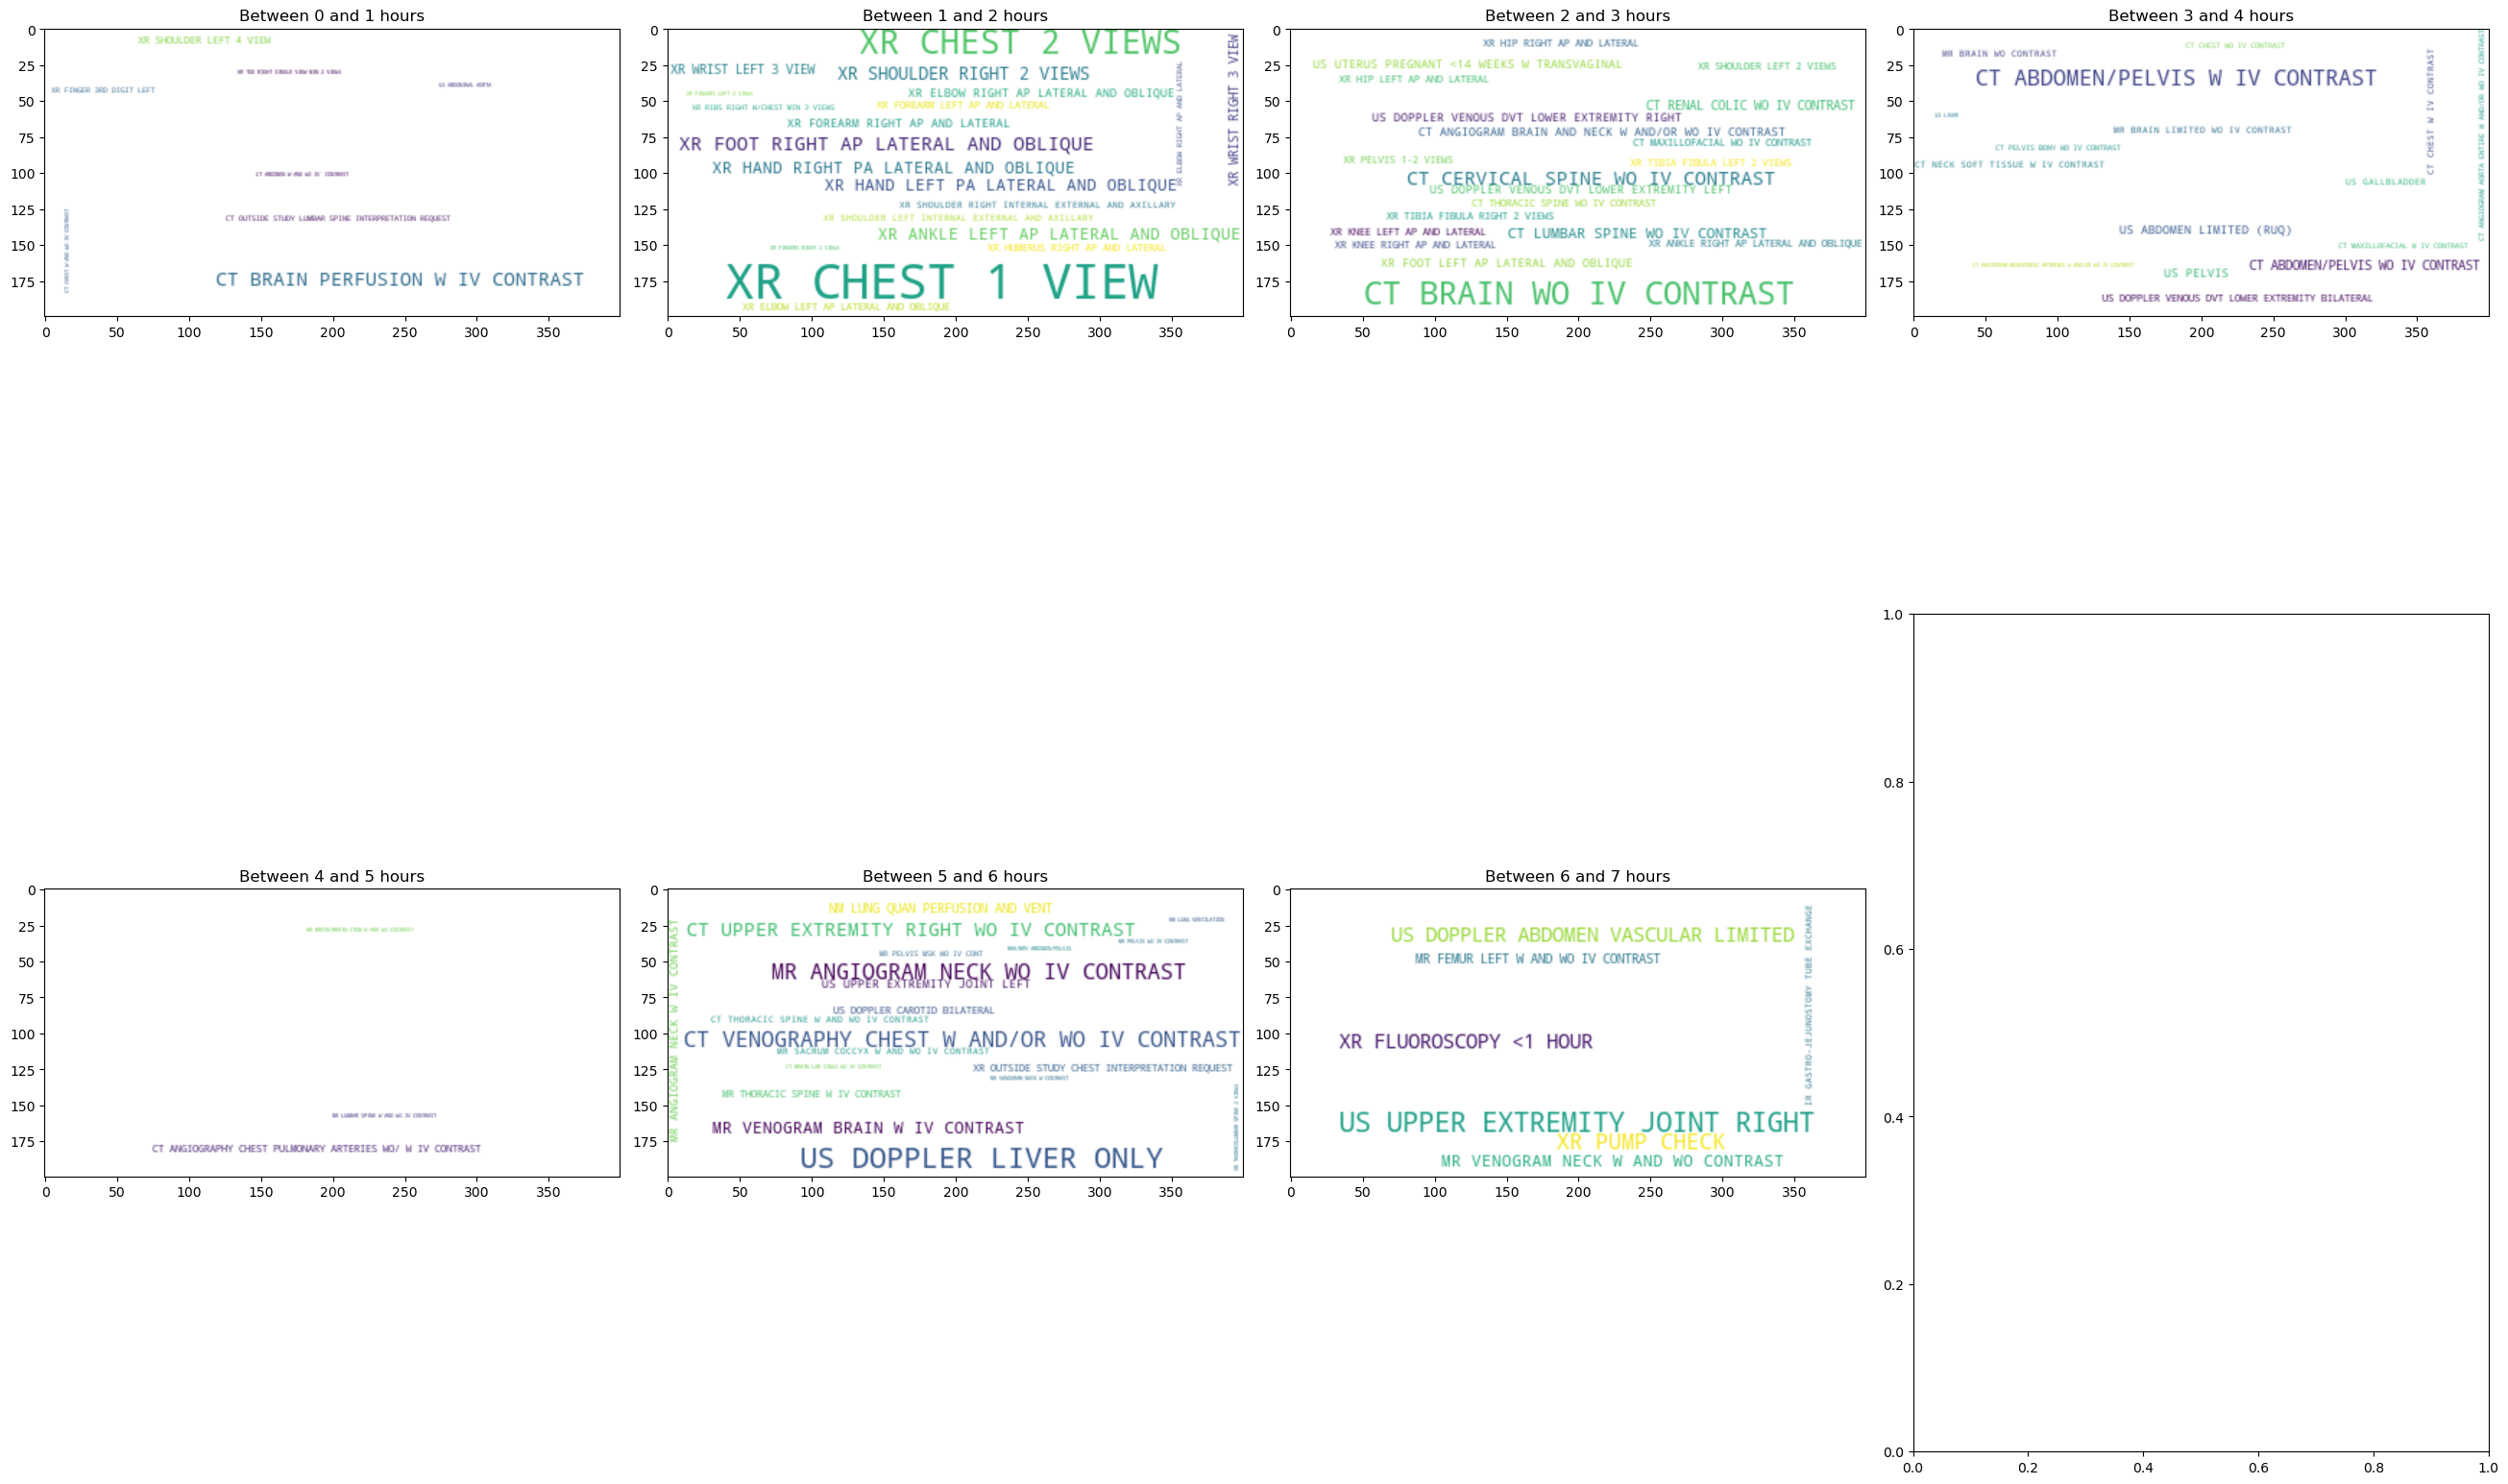

In [13]:
analyze_type('Order - Imaging')

# When is the Primary_DX assigned to patient? and how often does it changes?

In [100]:
dx_time = defaultdict(list)
for pat_id, df_grp in pat_groups:
    # print(df_grp[['PAT_ENC_CSN_ID', 'Primary_DX_Name', 'time_elapsed_min']].head(15))
    uniq_dx = df_grp['Primary_DX_Name'].nunique()
    if uniq_dx == 2:
        data = df_grp[df_grp['Primary_DX_Name']!='Unknown'].head(1)
        dx_time[pat_id].append((data['Primary_DX_Name'].iloc[0],data['time_elapsed_min'].iloc[0]))
    elif uniq_dx > 2:
        seen_dx = ['Unknown']
        for dx in df_grp['Primary_DX_Name'].unique():
            if dx == 'Unknown':
                continue
            data = df_grp[~(df_grp['Primary_DX_Name'].isin(seen_dx))].head(1)
            dx_time[pat_id].append((data['Primary_DX_Name'].iloc[0],data['time_elapsed_min'].iloc[0]))
            seen_dx.append(dx)
            
    

In [108]:
multi_dx_time = list(filter(lambda x: len(x[1])>1, dx_time.items()))

In [110]:
len(multi_dx_time)/len(dx_time)

0.07408862350722815

In [147]:
def get_statistics_about_i_dx(dx_time, idx): # 0-indexed
    first_dx_time = list(map(lambda x: x[1][idx] if len(x[1])>idx else (np.nan, np.nan), dx_time.items()))
    df_first_dx = pd.DataFrame(first_dx_time, columns=['dx', 'time'])
    df_first_dx.dropna(inplace=True)
    print(f'Number of patients with {idx+1} primary_dx is {len(df_first_dx)} ...')
    print('min, mean, median, max')
    print(df_first_dx['time'].min(),", ", df_first_dx['time'].mean(),", ",df_first_dx['time'].median(),", ",df_first_dx['time'].max())
    print('99th percentile')
    print(np.percentile(df_first_dx['time'], 99))
    print(df_first_dx['dx'].value_counts().iloc[:20])

In [148]:
get_statistics_about_i_dx(dx_time, 0)

Number of patients with 1 primary_dx is 101824 ...
min, mean, median, max
0.0 ,  50.27922542818981 ,  19.583333333333332 ,  19881.766666666666
99th percentile
362.334666666667
Chest pain, unspecified type                                                          9753
Abdominal pain, unspecified abdominal location                                        5281
SOB (shortness of breath)                                                             3773
Shortness of breath                                                                   2695
Fall, initial encounter                                                               2157
Dizziness                                                                             1962
Fever, unspecified fever cause                                                        1803
Tachycardia                                                                           1529
Acute confusional state                                                               1433
Weakn

In [149]:
get_statistics_about_i_dx(dx_time, 1)

Number of patients with 2 primary_dx is 7544 ...
min, mean, median, max
1.5666666666666667 ,  163.6909354012018 ,  108.92500000000001 ,  2834.9166666666665
99th percentile
728.7785
Abdominal pain, unspecified abdominal location                                        253
Chest pain, unspecified type                                                          234
Shortness of breath                                                                   158
Fever, unspecified fever cause                                                        151
Acute confusional state                                                               148
Acute abdominal pain                                                                  129
COVID-19                                                                              128
SOB (shortness of breath)                                                             110
Fall, initial encounter                                                                86
Nausea an

In [150]:
get_statistics_about_i_dx(dx_time, 2)

Number of patients with 3 primary_dx is 213 ...
min, mean, median, max
4.05 ,  236.02198748043818 ,  197.31666666666666 ,  1177.95
99th percentile
971.8606666666665
COVID-19                                                                                        6
Fever, unspecified fever cause                                                                  4
Anemia, unspecified type                                                                        4
Chest pain, unspecified type                                                                    4
AKI (acute kidney injury) (*)                                                                   4
Sepsis, due to unspecified organism, unspecified whether acute organ dysfunction present (*)    3
Hyponatremia                                                                                    3
Neck pain                                                                                       3
Abdominal pain, unspecified abdominal location     

In [151]:
get_statistics_about_i_dx(dx_time, 3)

Number of patients with 4 primary_dx is 7 ...
min, mean, median, max
17.933333333333334 ,  237.54285714285717 ,  190.93333333333334 ,  465.95
99th percentile
465.05899999999997
Spinal cord compression (*)                            1
Parainfluenza                                          1
Bruising at injection site                             1
Acute COVID-19                                         1
NSTEMI (non-ST elevation myocardial infarction) (*)    1
ESRD (end stage renal disease) (*)                     1
Anemia, unspecified type                               1
Name: dx, dtype: int64


In [146]:
get_statistics_about_i_dx(dx_time, 4)

Number of patients with 5 primary_dx is 0 ...
min, mean, median, max
nan ,  nan ,  nan ,  nan
99th percentile


IndexError: cannot do a non-empty take from an empty axes.

In [153]:
df.loc[df['Primary_DX_Name'] == 'COVID-19 virus infection', 'Primary_DX_ICD10']

113656     U07.1
113651     U07.1
113652     U07.1
113653     U07.1
113654     U07.1
           ...  
9988532    U07.1
9988535    U07.1
9988534    U07.1
9988533    U07.1
9988536    U07.1
Name: Primary_DX_ICD10, Length: 4642, dtype: object

In [154]:
df.loc[df['Primary_DX_Name'] == 'COVID-19', 'Primary_DX_ICD10']

26624       U07.1
26625       U07.1
26626       U07.1
26627       U07.1
26628       U07.1
            ...  
9917589     U07.1
9917590     U07.1
10009166    U07.1
10009167    U07.1
10165914    U07.1
Name: Primary_DX_ICD10, Length: 10917, dtype: object

In [155]:
df.loc[df['Primary_DX_Name'] == 'SOB (shortness of breath)', 'Primary_DX_ICD10']

1198        R06.02
1197        R06.02
1201        R06.02
1200        R06.02
1199        R06.02
             ...  
10171766    R06.02
10171767    R06.02
10171768    R06.02
10171769    R06.02
10171770    R06.02
Name: Primary_DX_ICD10, Length: 349831, dtype: object

In [156]:
df.loc[df['Primary_DX_Name'] == 'Shortness of breath', 'Primary_DX_ICD10']


480         R06.02
482         R06.02
481         R06.02
483         R06.02
484         R06.02
             ...  
10164044    R06.02
10164046    R06.02
10164047    R06.02
10164048    R06.02
10164049    R06.02
Name: Primary_DX_ICD10, Length: 255420, dtype: object

In [128]:
df_first_dx[(df_first_dx['time']>30)&(df_first_dx['time']>60)]['dx'].value_counts()

Abdominal pain, unspecified abdominal location     1281
Chest pain, unspecified type                       1220
SOB (shortness of breath)                           588
Shortness of breath                                 464
Fever, unspecified fever cause                      457
                                                   ... 
Tremulousness                                         1
Thoracic myelopathy                                   1
Blister (nonthermal) of abdominal wall, sequela       1
Accidental fall, initial encounter                    1
Open wound of abdomen, sequela                        1
Name: dx, Length: 4438, dtype: int64